In [1]:
from astropy.io import fits #to read in FITS files
from astropy.wcs import WCS #to read coordinates
from reproject import reproject_interp #to align images
import os # os.path to manipulate file paths 
import glob # finding pathnames (to search for certain fits files in folders and subfolders)
import numpy as np # math applied to arrays (important, no need to read pixel for pixel!)
from matplotlib import pyplot as plt #plot library 
from astropy.visualization import ZScaleInterval #create minimum and maximum Z values for plotting 
from astropy.stats import sigma_clip as astropy_sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import rankdata


In [2]:
# Returns the header and data of a .fit file.
def get_data(data_im):
    hdu = fits.open(data_im)[0]
    header = hdu.header 
    data = hdu.data
    wcs = WCS(hdu.header)

    return header, data, wcs

# Change the data with whatever fit you're using.
# Easiest to 'copy relative path' if you're using the GitHub folder.
# Don't forget to change \ to /.
fit_g = "NGC_4449_g_stack_astrometry.fits"
fit_r = "NGC_4449_r_stack_astrometry.fits"
fit_L = 'NGC_4449_L_stack_astrometry.fits'
fit_ha = 'NGC_4449_ha_stack_stephanie_astrometry.fits'

header_L, dat_L, wcs_L = get_data(fit_L)
header_g, dat_g, wcs_g = get_data(fit_g)
header_r, dat_r, wcs_r = get_data(fit_r)
header_ha, dat_ha, wcs_ha = get_data(fit_ha)


Below code for aligning images

In [3]:
# Reference coordinates.
wcs_ref = WCS(header_g)

# Aligns image with the reference coordinates.
def reproject_image(image_filename, wcs_ref):
    hdu = fits.open(image_filename)[0]
    array, footprint = reproject_interp(hdu, wcs_ref)
    return array

aligned_g = reproject_image(fit_g, wcs_ref)
aligned_r = reproject_image(fit_r, wcs_ref)
aligned_ha = reproject_image(fit_ha, wcs_ref)
aligned_L = reproject_image(fit_L, wcs_ref)

In [4]:
# Calculate distance from the center of each point
hdu = fits.open('NGC_4449_g_stack_astrometry.fits')[0]
image_data = aligned_g
wcs = WCS(hdu.header)


# Define the ICRS coordinates of the galaxy center
ra_center = 187.046325  # Right Ascension in degrees
dec_center = 44.093558  # Declination in degrees

# Create a SkyCoord 
sky_coord = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame='icrs')

# Convert WCS coordinates to pixel coordinates
x_center, y_center = wcs.world_to_pixel(sky_coord)

# Function to calculate distances from the center
def calc_distance(image, x_center, y_center):
    # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)

    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances


distances = calc_distance(image_data, x_center, y_center)


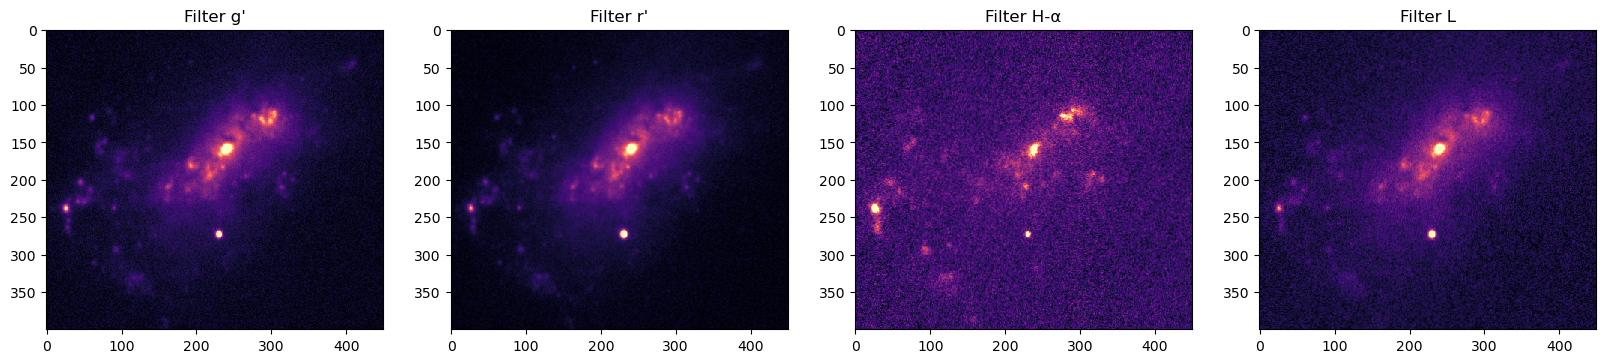

[[242.42623901 240.92489624 240.32821655 ... 244.11859131 241.9458313
  242.82366943]
 [240.6361084  241.38482666 242.86709595 ... 242.02996826 245.11288452
  243.75645447]
 [242.58370972 243.77558899 244.48565674 ... 244.08276367 244.60339355
  242.29205322]
 ...
 [239.13912964 242.44256592 244.4303894  ... 242.63023376 240.00009155
  241.97238159]
 [240.08200073 241.62408447 243.23171997 ... 240.04988098 242.87872314
  241.24224854]
 [240.22496033 244.41320801 243.45404053 ... 242.02505493 241.55453491
  238.74539185]]


In [15]:
# x, y limits to crop images 
x_min, x_max, y_min, y_max = 1750, 2200, 1900, 2300

# Crop the images
cropped_g= aligned_g[y_min:y_max, x_min:x_max]
cropped_r = aligned_r[y_min:y_max, x_min:x_max]
cropped_ha = aligned_ha[y_min:y_max, x_min:x_max]
cropped_L = aligned_L[y_min:y_max, x_min:x_max]
cropped_distances = distances[y_min:y_max, x_min:x_max]

# Visualize the cropped images
quantiles_g = np.percentile(cropped_g, (0.1, 99.9))
quantiles_r = np.percentile(cropped_r, (0.1, 99.9))
quantiles_ha = np.percentile(cropped_ha, (0.1, 99.9))
quantiles_L = np.percentile(cropped_L, (0.1, 99.9))
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cropped_g, cmap='magma', vmin = quantiles_g[0], vmax = quantiles_g[1], interpolation = 'nearest')
axs[0].set_title("Filter g'")
axs[1].imshow(cropped_r, cmap='magma', vmin = quantiles_r[0], vmax = quantiles_r[1], interpolation = 'nearest')
axs[1].set_title("Filter r'")
axs[2].imshow(cropped_ha, cmap='magma', vmin = quantiles_ha[0], vmax = quantiles_ha[1], interpolation = 'nearest')
axs[2].set_title("Filter H-α")
axs[3].imshow(cropped_L, cmap='magma', vmin = quantiles_L[0], vmax = quantiles_L[1], interpolation = 'nearest')
axs[3].set_title('Filter L')
plt.show()
print(cropped_g)

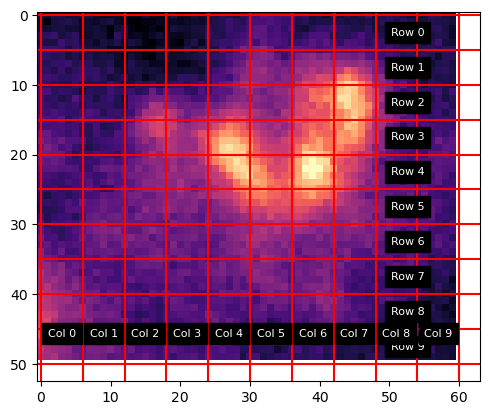

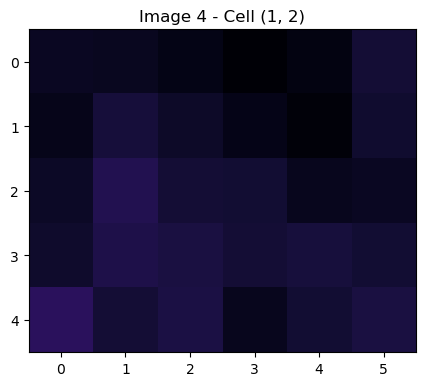

In [6]:
# Split an image up in a grid and create a list containing an array for each grid.
# Function to overlay grid and split image into grid parts
def create_grid(image, num_rows, num_cols):
    quantiles = np.percentile(image, (0.1, 99.9))
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='magma', vmin = quantiles[0], vmax = quantiles[1], interpolation = 'nearest')
    
    # Get image dimensions
    height, width = image.shape

    # Draw grid and annotate
    for i in range(num_rows + 1):
        ax.axhline(i * height / num_rows, color='red')
        if i < num_rows:
            ax.text(width - 5, (i + 0.5) * height / num_rows, f'Row {i}', color='white',
                    ha='right', va='center', fontsize=8, backgroundcolor='black')
    for j in range(num_cols + 1):
        ax.axvline(j * width / num_cols, color='red')
        if j < num_cols:
            ax.text((j + 0.5) * width / num_cols, height - 5, f'Col {j}', color='white',
                    ha='center', va='top', fontsize=8, backgroundcolor='black')

    # Extract grid data
    grid_data = []
    row_height = height // num_rows
    col_width = width // num_cols

    for i in range(num_rows):
        row_data = []
        for j in range(num_cols):
            grid_part = image[i * row_height:(i + 1) * row_height,
                              j * col_width:(j + 1) * col_width]
            row_data.append(grid_part)
        grid_data.append(row_data)

    plt.show()
    return grid_data

# Set the amount o columns and rows you want
num_rows = 10
num_cols = 10

grid_g = create_grid(cropped_g, num_rows, num_cols)

def plot_cell(grid_data, row, col, image_number):
    quantiles = np.percentile(grid_data, (0.1, 99.9))
    cell_data = grid_data[row][col]
    plt.figure(figsize=(5, 5))
    plt.imshow(cell_data, cmap='magma', vmin = quantiles[0], vmax = quantiles[1], interpolation = 'nearest')
    plt.title(f'Image {image_number} - Cell ({row}, {col})')
    plt.show()
    
plot_cell(grid_g, 1, 2, 4)


Calculate background noise and subtract it from the data

In [7]:
# Calculate background noise
def calc_background(image, xmin, xmax, ymin, ymax):
    background_region = image[ymin:ymax, xmin:xmax]
    average = np.mean(background_region)
    return average

xmin, xmax = 300, 450
ymin, ymax = 300, 400

bg_mean_L = calc_background(cropped_L, xmin, xmax, ymin, ymax)
bg_mean_ha = calc_background(cropped_ha, xmin, xmax, ymin, ymax)
bg_mean_r = calc_background(cropped_r, xmin, xmax, ymin, ymax)
bg_mean_g = calc_background(cropped_g, xmin, xmax, ymin, ymax)

no_bg_g = cropped_g - bg_mean_g
no_bg_r = cropped_r - bg_mean_r
no_bg_ha = cropped_ha - bg_mean_ha
no_bg_L = cropped_L - bg_mean_L

print()

c:\Users\juaop\anaconda3\envs\nsp1\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\juaop\anaconda3\envs\nsp1\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
# Function to sigma clip the data
# Sigma sets the amount of standarddeviations in which data is allowed
# Maxiters sets the amount of times clipping is done

# Remove hastags to enable sigma clipping
def sigma_clip(image, sigma, maxiters):
    #clipped_data = astropy_sigma_clip(image, sigma=sigma, maxiters=maxiters, cenfunc='median', stdfunc='std')
    # Fill up masked points with NaN values
    #return clipped_data.filled(np.nan)
    return image


sigma = 5
maxiters = 5
clipped_ha = sigma_clip(no_bg_ha, sigma, maxiters)
clipped_g = sigma_clip(no_bg_g, sigma, maxiters)
clipped_L = sigma_clip(no_bg_L, sigma, maxiters)
clipped_r = sigma_clip(no_bg_r, sigma, maxiters)
    

In [9]:
# Function to calculate the flux
def convert_to_magnitude(image, zero_point):
    # Add a min flux to avoid log(0)
    min_flux = 1e-10
    flux = -2.5 * np.log10(np.maximum(image,min_flux)/60) + zero_point
    return flux

# Zero_point is the apparent magnitude of a known star
# Should be different for each filter
zero_point = 25
magnitude_ha = convert_to_magnitude(clipped_ha, zero_point)
magnitude_L = convert_to_magnitude(clipped_L, zero_point)
magnitude_r = convert_to_magnitude(clipped_r, zero_point)
magnitude_g = convert_to_magnitude(clipped_g, zero_point)

magnitude_g_2 = convert_to_magnitude(cropped_g, zero_point)
magnitude_r_2 = convert_to_magnitude(cropped_r, zero_point)


print(magnitude_g_2)


[[23.42549549 23.42827755 23.41979755 ... 23.41693315 23.4282978
  23.42903775]
 [23.43474932 23.44648771 23.42589046 ... 23.4212549  23.42223557
  23.4249105 ]
 [23.43037752 23.43009407 23.42515686 ... 23.41375619 23.42334792
  23.4347179 ]
 ...
 [23.33248061 23.34451862 23.3556554  ... 23.42732774 23.42378982
  23.42370111]
 [23.33789023 23.35073414 23.35565455 ... 23.42945603 23.42766795
  23.42958505]
 [23.34609375 23.35223442 23.34431092 ... 23.42609181 23.42543999
  23.42992422]]


In [10]:
# Calculates the color index
def calc_color_index(filter1, filter2):
    color_index = filter1 - filter2
    return color_index

color_index_g_min_r = calc_color_index(magnitude_g, magnitude_r)
color_2 = calc_color_index(magnitude_g_2, magnitude_r_2)

In [11]:
# Flatten arrays to use it for plot
color_index_flat = color_index_g_min_r.flatten()
g_flat = magnitude_g.flatten()
distances_flat = cropped_distances.flatten()

color_2 = color_2.flatten()
g_2_flat = magnitude_g_2.flatten()

# Replace certain values with NaN values
def replace_with_nan(array, number_to_replace):
    array = np.array(array, dtype=float)  # Convert to float to allow NaN values
    array[array == number_to_replace] = np.nan
    return array

# G_flat had ~160000 times the same value.
array = g_flat
g_flat_fix = replace_with_nan(array, 54.44537812595911)

# Color_index_flat had >20000 times the same value
array = color_index_flat
color_index_flat_fix = replace_with_nan(array, 0.0)

In [12]:
# Mask the weird lineair line
color_index_min = -30
color_index_max = -12.5
g_flat_min = 26
g_flat_max = 41

linear_feature_indices = (color_index_flat >= color_index_min) & (color_index_flat <= color_index_max) & \
                         (g_flat >= g_flat_min) & (g_flat <= g_flat_max)
non_linear_feature_indices = ~linear_feature_indices

# Convert the values belonging to the lineair line to NaN values
g_flat[linear_feature_indices] = np.nan
color_index_flat[linear_feature_indices] = np.nan
distances_flat[linear_feature_indices] = np.nan

# Check if the shapes are equal 
print(g_flat.shape)
print(color_index_flat.shape)
print(distances_flat.shape)
print(g_2_flat)
print(color_2)

(3000,)
(3000,)
(3000,)
[23.42549549 23.42827755 23.41979755 ... 23.42609181 23.42543999
 23.42992422]
[0.34410562 0.34785324 0.33889471 ... 0.34847989 0.34229038 0.34315708]


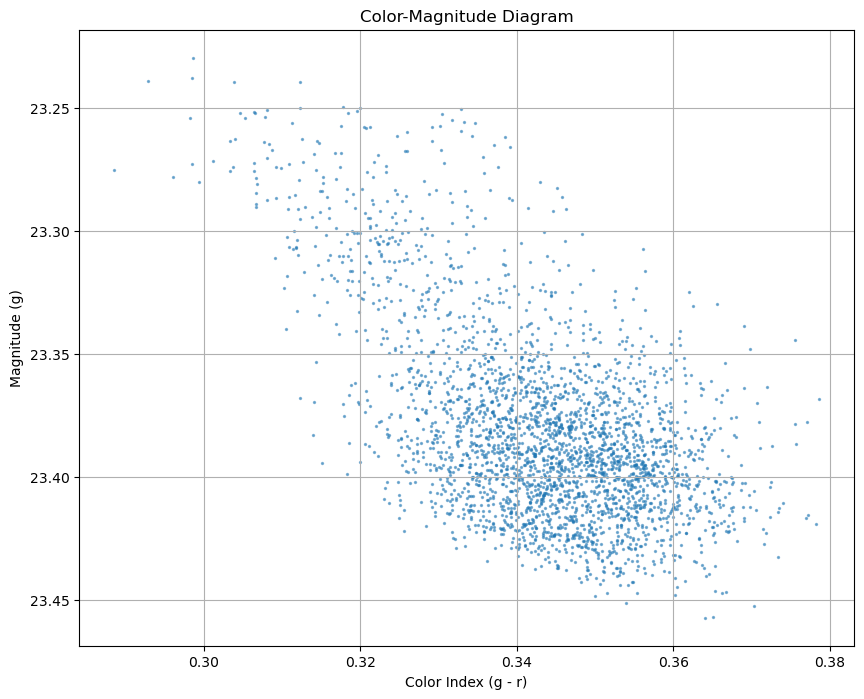

In [13]:
# Combine the valid indices into one variable
valid_indices = ~np.isnan(g_flat_fix) & ~np.isnan(color_index_flat_fix)
combined_indices = valid_indices & non_linear_feature_indices

# Mask the invalid indices
g_flat = g_flat_fix[combined_indices]
color_index_flat = color_index_flat_fix[combined_indices]
#distances_flat = distances_flat[combined_indices]


plt.figure(figsize=(10, 8))
plt.scatter(color_2, g_2_flat, s=2, alpha=0.5)
plt.xlabel('Color Index (g - r)')
plt.ylabel('Magnitude (g)')
plt.title('Color-Magnitude Diagram')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
#plt.colorbar()
plt.grid(True)
plt.show()

In [14]:
##NIEUWE CODE
##Over de correlatie tussen de de gebruikte arrays


# Calculate Pearson's r
def pearson_r(x, y):
    n = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    covariance = np.sum((x - mean_x) * (y - mean_y)) / (n - 1)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    return covariance / (std_x * std_y)

r = pearson_r(color_2, g_2_flat)
print("Pearson's r:", r)


# Calculate Spearman's rho
def spearman_rho(x, y):
    n = len(x)
    rank_x = rankdata(x)
    rank_y = rankdata(y)
    d = rank_x - rank_y
    d_squared = np.sum(d**2)
    return 1 - (6 * d_squared) / (n * (n**2 - 1))

rho = spearman_rho(color_2, g_2_flat)
print("Spearman's rho:", rho)



Pearson's r: 0.5746954076255437
Spearman's rho: 0.4488795294310588
